In [1]:
import asyncio
import numpy as np
import quaternion

from intrepid_environment.simulator import Simulator

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
# import subprocess

# def run_detached(command):
#     process = subprocess.Popen(
#         command,
#         stdout=subprocess.PIPE,
#         stderr=subprocess.PIPE,
#     )
#     print(f"Process started with PID: {process.pid}")
#     return process

In [4]:
# my_command = ["intrepid/intrepid-sim", "--no-script"]
# process = run_detached(my_command)

In [5]:
sim = Simulator()
await sim.connect()

await sim.rpc("session.restart")
entity = await sim.rpc("map.spawn_uav", {
    "robot_id": 0,
    "position": {
        "x": 0,
        "y": 0,
        "z": 0,
    },
})
await sim.rpc("session.run")

Setup trajectory for drone to follow.

In [6]:
from quadcopter_control.trajectory import Trajectory, TrajectoryPoint

In [7]:
async def sim_step(motors):

    (sim_time, _, drone_state) = await asyncio.gather(
            sim.step(),
            sim.rpc(f"object_{entity}.actuator_control", motors),
            sim.rpc("script.eval", {
                "code": """{
                    position = sim.object.position(ARGS),
                    attitude = sim.object.rotation_quat(ARGS),
                    velocity = sim.object.linear_velocity(ARGS),
                    omega = sim.object.angular_velocity(ARGS),
                    acceleration = sim.object.acceleration(ARGS),
                }""",
                "args": entity,
            }),
        )

    acceleration = np.array([drone_state['acceleration']['y'],
                             drone_state['acceleration']['x'],
                             drone_state['acceleration']['z']], dtype=np.float64)

    position = np.array([drone_state['position']['y'],
                        drone_state['position']['x'],
                        drone_state['position']['z']], dtype=np.float64)

    velocity = np.array([drone_state['velocity']['y'],
                        drone_state['velocity']['x'],
                        drone_state['velocity']['z']], dtype=np.float64)

    attitude = np.quaternion(drone_state['attitude'][3],
                             drone_state['attitude'][0],
                             drone_state['attitude'][1],
                             drone_state['attitude'][2])

    omega = np.array([drone_state['omega']['xy'],
                     drone_state['omega']['zx'],
                     drone_state['omega']['yz']], dtype=np.float64)

    return {
        'time': sim_time,
        'acceleration': acceleration,
        'position': position,
        'velocity': velocity,
        'attitude': attitude,
        'omega': omega
    }

In [8]:
async def get_trajectory_with_initial_position():
    state = await sim_step([0, 0, 0, 0])

    starting_point = TrajectoryPoint(
        time=state['time'],
        acceleration=state['acceleration'],
        attitude=state['attitude'],
        omega=state['omega'],
        position=state['position'],
        velocity=state['velocity'],
    )

    trajectory = Trajectory()
    trajectory.add_point(starting_point)

    return trajectory

In [9]:
trajectory_time_offset = 0
dp = np.zeros(3)

def get_next_trajectory_point(trajectory, sim_time, dt, dp):
    pt = trajectory.next_trajectory_point((sim_time + dt) / 1000.0)
    pt.position += dp
    return pt

In [10]:
from quadcopter_control.controller import QuadcopterController, calculate_drone_moment_of_inertia

In [11]:
DRONE_HEIGHT = 0.028
DRONE_RADIUS = 0.05
DRONE_MASS = 0.041

In [12]:
(Ixx, Iyy, Izz) = calculate_drone_moment_of_inertia(DRONE_HEIGHT, DRONE_RADIUS, DRONE_MASS)
(Ixx, Iyy, Izz)

(2.830366666666667e-05, 2.830366666666667e-05, 5.125000000000001e-05)

## Scenario 0: Zero Gains

Test whether controller runs without controller gains set.

In [13]:
trajectory = await get_trajectory_with_initial_position()

In [14]:
DT_MS = 15.625 # 64 hz

In [15]:
quadcopter_controller = QuadcopterController(
    DT_MS,
    DRONE_MASS,
    Ixx, Iyy, Izz,
    max_tilt_angle=0.52,
    max_ascent_rate=20.0
)

In [16]:
trajectory = await get_trajectory_with_initial_position()

MOTOR_SCALE = 150

async def control_step(state):
    motors = quadcopter_controller.run_control(
        traj_pt=trajectory.next_trajectory_point((state['time'] + DT_MS*1e3)/1e6),
        est_pos=state['position'],
        est_vel=state['velocity'],
        est_omega=state['omega'],
        est_att=state['attitude'],
    ) * MOTOR_SCALE

    return await sim_step(motors.tolist())

## Scenario 1: Altitude Control

Tune gains until drone stays in place. on a desired height.

In [17]:
state = await sim_step([0, 0, 0, 0])
trajectory = await get_trajectory_with_initial_position()

In [18]:
# add 500 datapoints so drone stays in place
sim_time = (await sim_step([0, 0, 0, 0]))['time']
n_episodes = 1000

for i in range(0, n_episodes):
    trajectory.add_point(TrajectoryPoint(
        time=(sim_time + (i*DT_MS*1e3) / 1e6),
        position=np.array([0.0, 0.0, 5.0]),
        velocity=np.zeros(3),
        acceleration=np.zeros(3),
        attitude=np.quaternion(1.0, 0.0, 0.0, 0.0),
        omega=np.array([0.0, 0.0, 0.0])
    ))

Set controller gains. Test only integrated error of altitude controller.

In [19]:
def control_step(state, dt):
    traj_pt = trajectory.next_trajectory_point((state['time']+ dt * 1e3) / 1e6)

    thrust = quadcopter_controller.altitude_control(
        traj_pt.position[2],
        traj_pt.velocity[2],
        np.max([0, state['position'][2]]),
        state['velocity'][2],
        state['attitude'],
        traj_pt.acceleration[2],
        dt / 1e3
    )

    # thrust_margin = 0.1 * (max_motor_thrust - min_motor_thrust)
    # clipped_thrust = np.clip(thrust_cmd, min_motor_thrust, max_motor_thrust)

    motors = quadcopter_controller.generate_motor_commands(thrust, np.zeros(3))
    motors *= MOTOR_SCALE
    motors = np.clip(motors, 45, 100)

    return (motors, thrust)

In [20]:
async def tune_altitude_control(
        kp_pqr=np.array([95.0, 95.0, 6.0]),
        ki_pos_z=8.0,
        kp_pos_z=5.0,
        kp_vel_z=2.0,
        kappa=2.0,
):

    # global entity

    # await sim.rpc("session.restart")
    # entity = await sim.rpc("map.spawn_uav", {
    #     "robot_id": 0,
    #     "position": {
    #         "x": 0,
    #         "y": 0,
    #         "z": 0,
    #     },
    # })
    # await sim.rpc("session.run")

    quadcopter_controller.set_gains(
        kp_pqr, ki_pos_z, kp_pos_z, kp_vel_z, kappa)

    altitude_log = []
    thrust_log = []
    motor_log = []

    state = await sim_step([0, 0, 0, 0])

    for _ in range(1500):
        (motors, thrust) = control_step(state, DT_MS)

        altitude_log.append(state['position'][2])
        thrust_log.append(thrust)
        motor_log.append(np.mean(motors))

        state = await sim_step(motors.tolist())

    return (altitude_log, thrust_log, motor_log)

In [21]:
import matplotlib.pyplot as plt

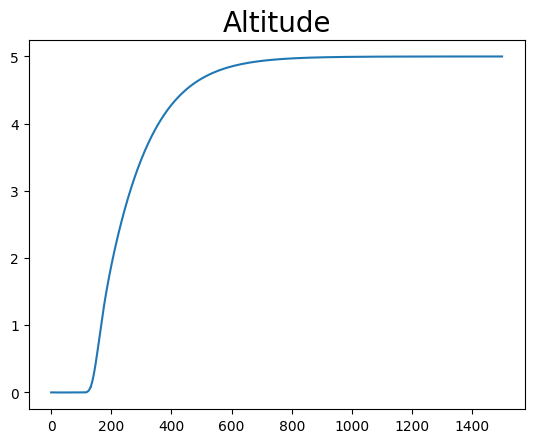

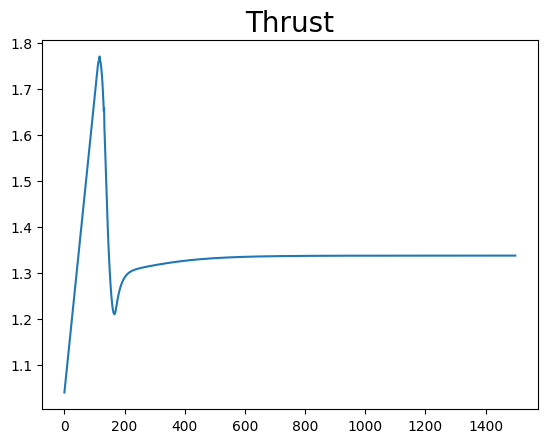

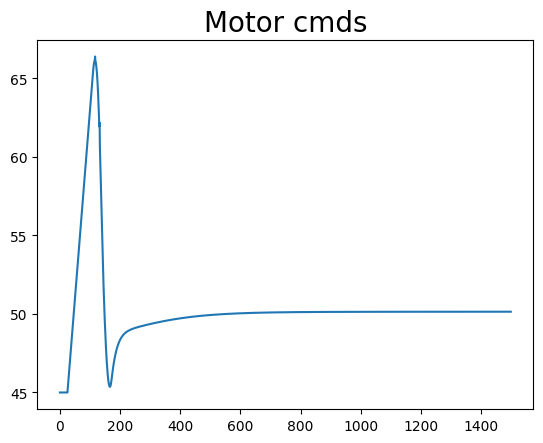

In [22]:
(altitude_log, thrust_log, motor_log) = await tune_altitude_control(ki_pos_z=7.0, kp_pos_z=7.0, kp_vel_z=7.0)

plt.plot(altitude_log)
plt.title("Altitude", fontsize=20)
plt.show()

plt.plot(thrust_log)
plt.title("Thrust", fontsize=20)
plt.show()

plt.plot(motor_log)
plt.title("Motor cmds", fontsize=20)
plt.show()